**Description:**

In this document, we utilize geographical maps to visualize the data. Each state's values are depicted on the map, and they are color-coded based on the PM2.5 legend.

We use the geopandas library to visualize maps between 2012 and 2015, highlighting a notable reduction in PM2.5 levels.

We also employ Folium, an interactive mapping tool, to display the predicted PM2.5 values generated by our trained model.

In [1]:
import pandas as pd
import json

# List of USA states and their abbreviations
states = [
    {"State": "Alabama", "Abbreviation": "AL"},
    {"State": "Alaska", "Abbreviation": "AK"},
    {"State": "Arizona", "Abbreviation": "AZ"},
    {"State": "Arkansas", "Abbreviation": "AR"},
    {"State": "California", "Abbreviation": "CA"},
    {"State": "Colorado", "Abbreviation": "CO"},
    {"State": "Connecticut", "Abbreviation": "CT"},
    {"State": "Delaware", "Abbreviation": "DE"},
    {"State": "Florida", "Abbreviation": "FL"},
    {"State": "Georgia", "Abbreviation": "GA"},
    {"State": "Hawaii", "Abbreviation": "HI"},
    {"State": "Idaho", "Abbreviation": "ID"},
    {"State": "Illinois", "Abbreviation": "IL"},
    {"State": "Indiana", "Abbreviation": "IN"},
    {"State": "Iowa", "Abbreviation": "IA"},
    {"State": "Kansas", "Abbreviation": "KS"},
    {"State": "Kentucky", "Abbreviation": "KY"},
    {"State": "Louisiana", "Abbreviation": "LA"},
    {"State": "Maine", "Abbreviation": "ME"},
    {"State": "Maryland", "Abbreviation": "MD"},
    {"State": "Massachusetts", "Abbreviation": "MA"},
    {"State": "Michigan", "Abbreviation": "MI"},
    {"State": "Minnesota", "Abbreviation": "MN"},
    {"State": "Mississippi", "Abbreviation": "MS"},
    {"State": "Missouri", "Abbreviation": "MO"},
    {"State": "Montana", "Abbreviation": "MT"},
    {"State": "Nebraska", "Abbreviation": "NE"},
    {"State": "Nevada", "Abbreviation": "NV"},
    {"State": "New Hampshire", "Abbreviation": "NH"},
    {"State": "New Jersey", "Abbreviation": "NJ"},
    {"State": "New Mexico", "Abbreviation": "NM"},
    {"State": "New York", "Abbreviation": "NY"},
    {"State": "North Carolina", "Abbreviation": "NC"},
    {"State": "North Dakota", "Abbreviation": "ND"},
    {"State": "Ohio", "Abbreviation": "OH"},
    {"State": "Oklahoma", "Abbreviation": "OK"},
    {"State": "Oregon", "Abbreviation": "OR"},
    {"State": "Pennsylvania", "Abbreviation": "PA"},
    {"State": "Rhode Island", "Abbreviation": "RI"},
    {"State": "South Carolina", "Abbreviation": "SC"},
    {"State": "South Dakota", "Abbreviation": "SD"},
    {"State": "Tennessee", "Abbreviation": "TN"},
    {"State": "Texas", "Abbreviation": "TX"},
    {"State": "Utah", "Abbreviation": "UT"},
    {"State": "Vermont", "Abbreviation": "VT"},
    {"State": "Virginia", "Abbreviation": "VA"},
    {"State": "Washington", "Abbreviation": "WA"},
    {"State": "West Virginia", "Abbreviation": "WV"},
    {"State": "Wisconsin", "Abbreviation": "WI"},
    {"State": "Wyoming", "Abbreviation": "WY"},
]

# Read the JSON file
with open("./us-states.json", "r") as file:
    data = json.load(file)

# Initialize lists to store data
abbreviations = []
state_names = []
coordinates = []

# Extract data from JSON
for item in data["features"]:
    abbreviation = item["id"]
    name = item["properties"]["name"]
    coords = item["geometry"]["coordinates"]

    abbreviations.append(abbreviation)
    state_names.append(name)
    coordinates.append(coords)

df = pd.DataFrame(
    {
        "State Abbreviation": abbreviations,
        "State": state_names,
        "Coordinates": coordinates,
    }
)

In [27]:
predicted_df = pd.read_csv("../Predictions/predicted_2022_values.csv")

merged_df = df.merge(predicted_df, on="State", how="left")
merged_df["Predicted PM2.5"].fillna(0, inplace=True)
merged_df.head()

,State Abbreviation,State,Coordinates,Predicted PM2.5,PM2.5_2022_Actual
0,AL,Alabama,"[[[-87.359296, 35.00118], [-85.606675, 34.9847...",11.809813,8.137220
1,AK,Alaska,"[[[[-131.602021, 55.117982], [-131.569159, 55....",0.000000,NaN
2,AZ,Arizona,"[[[-109.042503, 37.000263], [-109.04798, 31.33...",4.101122,7.560903
3,AR,Arkansas,"[[[-94.473842, 36.501861], [-90.152536, 36.496...",10.566002,8.427775
4,CA,California,"[[[-123.233256, 42.006186], [-122.378853, 42.0...",7.758231,8.928093


In [28]:
import folium

def get_interactive_map(merged_df):
    map = folium.Map(location=[45, -102], zoom_start=4)
    folium.Choropleth(
        geo_data="./us-states.json",
        data=merged_df,
        columns=["State Abbreviation", "Predicted PM2.5"],
        key_on="feature.id",
        fill_color="YlOrBr",
        fill_opacity=0.3,
        line_opacity=1.0,
        legend_name="PM2.5",
        highlight=True,
        name="PM2.5",
        tooltip=folium.GeoJsonTooltip(
            fields=["State Abbreviation", "PM2.5"],
            aliases=["State", "Predicted PM2.5"],
            localize=True,
            sticky=True,
        ),
    ).add_to(map)

    for feature in folium.features.GeoJson("./us-states.json").data["features"]:
        state_name = feature["properties"]["name"]
        pm25_value = (
            merged_df[merged_df["State"] == state_name]["Predicted PM2.5"].values[0]
            if state_name in merged_df["State"].values
            else "Data not available"
        )
        folium.GeoJson(
            feature,
            style_function=lambda x: {"fillOpacity": 0.01, "color": "black", "weight": 0.1},
            highlight_function=lambda x: {
                "fillOpacity": 0.4,
                "color": "black",
                "weight": 0.1,
            },
            tooltip=f"{state_name}<br>PM2.5: {pm25_value}",
        ).add_to(map)
    return map

In [29]:
def get_heat_map(year):
    import geopandas as gpd
    import matplotlib.pyplot as plt
    from matplotlib.colors import Normalize
    from matplotlib.cm import ScalarMappable
    df = pd.read_csv("../Data/pollution_data0015.csv")
    # Load the shapefile (replace 'usa_shapefile.shp' with 'USA_States.shp')
    gdf = gpd.read_file('USA_States.shp')

    # Filter the DataFrame for the year
    df_year = df[df['Year'] == year]

    # Merge the GeoDataFrame with the filtered DataFrame using the 'State' column
    gdf = gdf.merge(df_year, left_on='STATE_NAME', right_on='State')

    # Create the figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    # Create a colormap from cool to warm colors
    cmap = plt.get_cmap('coolwarm')

    # Normalize the PM2.5 values to the new range (4 to 10)
    norm = Normalize(vmin=4, vmax=10)

    # Create a ScalarMappable for color mapping
    sm = ScalarMappable(cmap=cmap, norm=norm)

    # Plot the map with colored states
    gdf.boundary.plot(ax=ax, linewidth=2, color='black')

    for geom, value, state_name in zip(gdf['geometry'], gdf['PM2.5'], gdf['STATE_NAME']):
        # Check if it's a MultiPolygon
        if geom.geom_type == 'MultiPolygon':
            for poly in geom.geoms:
                color = cmap(norm(value))
                plt.fill(*poly.exterior.xy, color=color, edgecolor='black')
        else:
            color = cmap(norm(value))
            plt.fill(*geom.exterior.xy, color=color, edgecolor='black')

        # Annotate each state with its name
        x, y = geom.centroid.coords[0]
        ax.annotate(state_name, (x, y), fontsize=8, ha='center', va='center', color='white')

    # Set title and labels
    ax.set_title(f'USA Map with PM2.5 Values (Year {year})')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Add a color bar with the updated range
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label='PM2.5 Values (4-10)')

    plt.show()

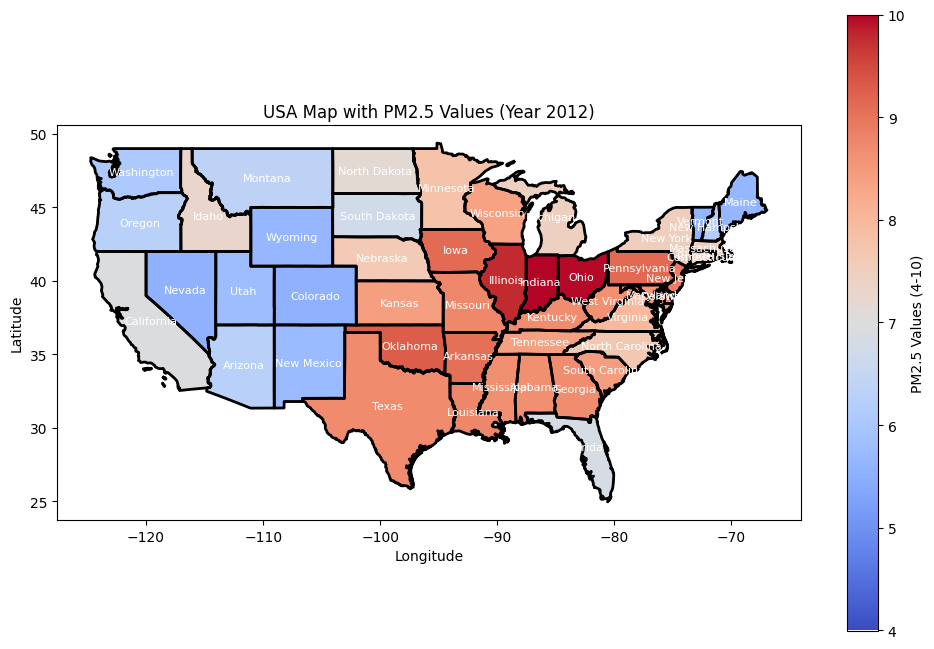

In [30]:
get_heat_map(2012)

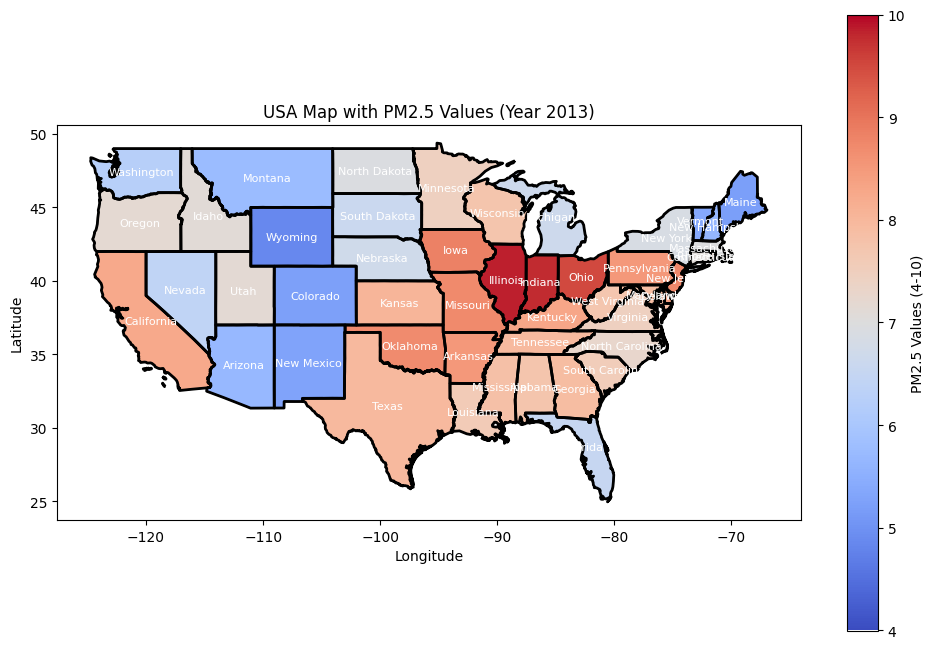

In [31]:
get_heat_map(2013)

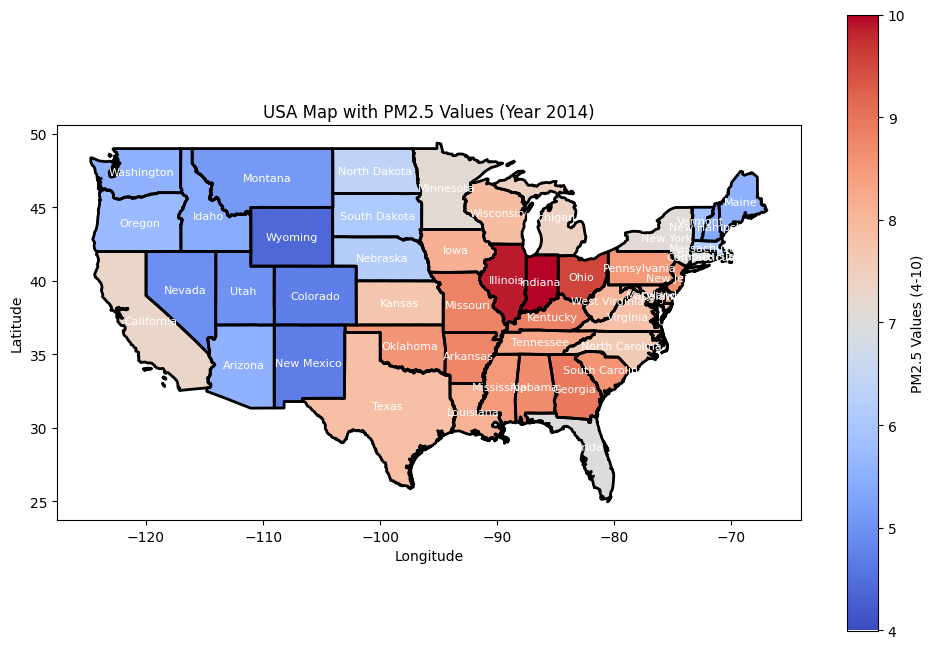

In [32]:
get_heat_map(2014)

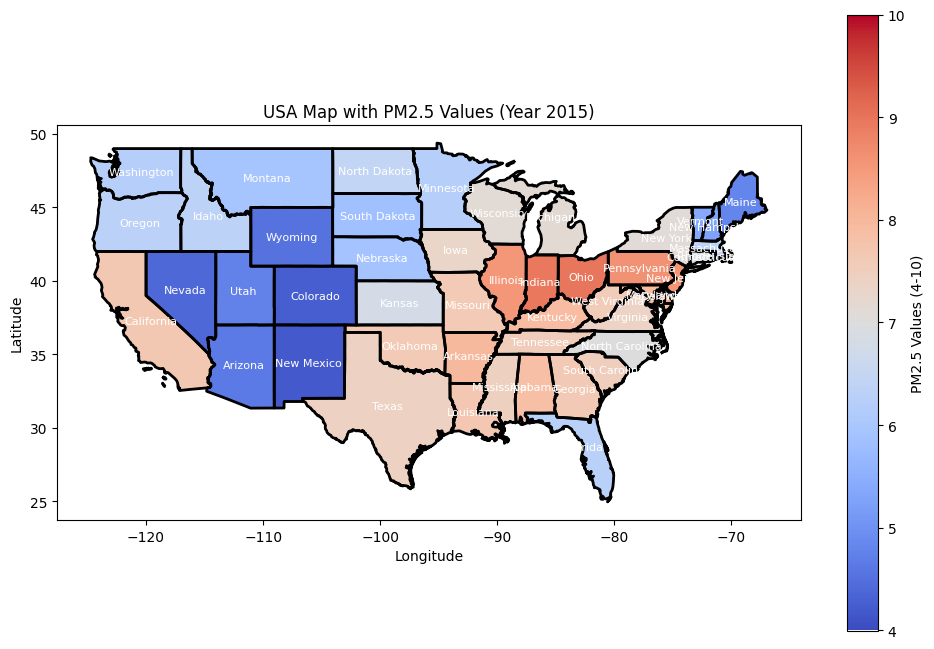

In [33]:
get_heat_map(2015)

In [34]:
get_interactive_map(merged_df)